In [41]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u 
import astropy.units.imperial as ui 
import os 
from pyXSteam.XSteam import XSteam
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, FormatStrFormatter
from math import pi

ui.enable()
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

if not os.path.exists('figs'): 
    os.mkdir('figs')

from helper import print_value


Reactor Params

In [42]:
from helper import calc_Ax, calc_De, calc_sg_location
steamTable = XSteam(XSteam.UNIT_SYSTEM_FLS)
n_p = 10 
P_c = 22060 * u.kPa
Qdot = 3976 * u.MW
gamma_f = 0.974
P = 1040 * ui.psi
T_fd = 410 * ui.deg_F
F_q = 3.15 
F_z = 1.45 
H_f = (178 * ui.inch).to(ui.ft)
D = (0.4039 * ui.inch).to(ui.ft)
D_i = (0.3441 * ui.inch).to(ui.ft)
R_o = D / 2 
R_i = D_i / 2
D_f = (0.3386 * ui.inch).to(ui.ft)
S = (0.5098 * ui.inch).to(ui.ft)
k_c = 9.6 * ui.BTU / (u.h * ui.ft * ui.deg_F)
H_G = 1200 * ui.BTU / (u.h * ui.ft**2 * ui.deg_F)
n_a = 872 
n_fr_a = 92 
n_w_a = 8 
n = n_a * (n_fr_a + n_w_a)
N_sg = 8 
K_sg = 0.6 
K_in = 1.5 
K_out = 1.0 
K_dc = 2.5
V_d = (280 * ui.inch).to(ui.ft)
C_d = (184 * ui.inch).to(ui.ft)
Ax_dc = pi * (V_d**2 - C_d**2) / 4
De_dc = 4 * Ax_dc / (pi * V_d)
H_c = 12 * ui.ft 
Ax_c = calc_Ax(S, D)
Ax_w = pi * D**2 / 4 
De = calc_De(Ax_c, D)
dz = 1e-2 * ui.ft 
z_range = np.arange(0, H_f.value, dz.value) * ui.ft 
sg_locations = calc_sg_location(N_sg, H_f)
sg_idx = np.zeros(sg_locations.size, int)
K_array = np.zeros((2 + N_sg, ))
K_array[0] = K_in 
K_array[-1] = K_out 
K_array[1:-1] = K_sg 
CPR_goal = 1.28 
QMR_goal = 1.17 
T_melt = 4890 * ui.deg_F

Constant Fluid Properties

In [43]:
h_f = steamTable.hL_p(P.value) * ui.BTU / ui.lbm
h_g = steamTable.hV_p(P.value) * ui.BTU / ui.lbm
h_fg = h_g - h_f
h_fd = steamTable.h_pt(P.value, T_fd.value) * ui.BTU / ui.lbm
rho_f = steamTable.rhoL_p(P.value) * ui.lbm / ui.ft**3 
rho_g = steamTable.rhoV_p(P.value) * ui.lbm / ui.ft**3
mu_f = steamTable.my_ph(P.value, h_f.value) * ui.lb / (ui.ft * u.h)
mu_g = steamTable.my_ph(P.value, h_g.value) * ui.lb / (ui.ft * u.h)
T_sat = steamTable.tsat_p(P.value) * ui.deg_F
Cp = steamTable.CpL_p(P.value) * ui.BTU / (ui.lbm * ui.Fahrenheit)
k = steamTable.tcL_p(P.value) * ui.BTU / (ui.ft * u.h * ui.Fahrenheit)

mdot_fd = (Qdot / (h_g - h_fd)).to(ui.lbm / u.hr)
print_value('mdot_fd', mdot_fd)

mdot_fd = 1.69E+07 lb / h


Finding the spacer grid indicies 

In [44]:
for i in range(sg_locations.size): 
    sg_idx[i] = int(np.where(z_range.value <= sg_locations[i].value)[0][-1])

Extrapolated Distance

i = 2028757
i = 2028758
Omega = 2.02876


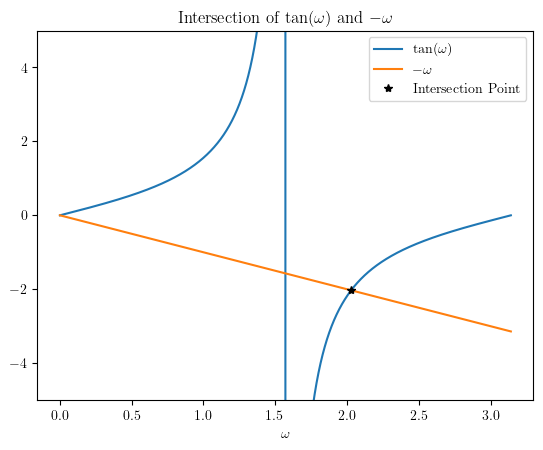

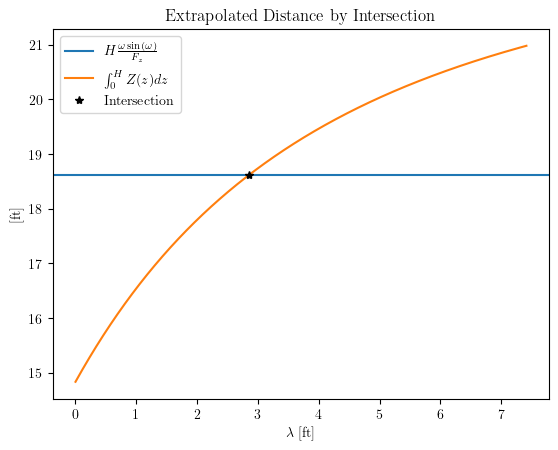

lambda = 2.85E+00 ft


In [45]:
from helper import find_lambda, int_shape, print_value
lambda_, omega = find_lambda(D, H_f, F_z)

In [46]:
qpp_bar = ((gamma_f * Qdot) / (n * pi * D * H_f * omega * np.sin(omega))).to(ui.BTU / (ui.ft**2 * u.hr))
qpp_hot = F_q * qpp_bar 

Calculating the mass flux in the hot channel 

In [47]:
from helper import calc_Re, friction_factor, calc_h_bar, non_boiling_height_BOC_CISE_4, enthalpy_profile, qpp_crit_CISE_4
from helper import hc_Weisman, condutivity_int_UO2, fluid_temp, shape, fuel_surface_temp, heat_flux
from helper import G_from_DP, dP_from_G, calc_h_in, x_e, calc_pump_HP
deltaP = 87 * ui.psi 

# dummy starting values 
e = 1e-3
H_0_curr = 1 * ui.ft 

f = 1.2e-2
f_dc = f
x_bar = 0 
rho_bar = rho_f
rho_l_array = rho_f * np.ones(K_array.shape)
rho_in = rho_f
x_array = np.zeros(K_array.shape)
G_curr = G_from_DP(deltaP, n, Ax_c, Ax_dc, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in)

CPR_curr = 0 
QMR_curr = 0 
T_o_max = T_melt


while CPR_curr < CPR_goal or np.abs(CPR_curr - CPR_goal) > e * 10 or T_o_max > T_melt:
    # Calculating the mass flux in the average channel 
    G_prev = 0 * G_curr.unit 
    deltaP_curr = 0 * deltaP.unit
    while np.abs((G_curr - G_prev).value) >= e and np.abs((deltaP_curr - deltaP).value) >= e: 
        mdot_curr = G_curr * Ax_c 
        G_dc_curr = mdot_curr * n / Ax_dc
        deltaP_curr = dP_from_G(G_curr, G_dc_curr, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in)
        # updating the core inlet enthalpy     
        #h_in = (mdot_fd / (n * mdot_curr)) * h_fd + (1 - (mdot_fd / (n * mdot_curr))) * h_f 
        h_in = calc_h_in(n, mdot_fd, h_fd, mdot_curr, h_f)
        rho_in = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        T_in = steamTable.t_ph(P.value, h_in.value) * ui.deg_F 
        # updating the core average enthalpy 
        h_bar = calc_h_bar(h_in, D, gamma_f, mdot_curr, qpp_bar, H_f, lambda_)
        # updating the core average density 
        rho_bar = steamTable.rho_ph(P.value, h_bar.value) * ui.lbm / ui.ft**3 
        # updating downcomer friction factor 
        Re = calc_Re(G_dc_curr, De_dc, mu_f)
        f_dc = friction_factor(Re)
        # updating friction factor 
        Re = calc_Re(G_curr, De, mu_f)
        f = friction_factor(Re)
        # updating the non boiling height 
        H_0_curr = non_boiling_height_BOC_CISE_4(D, G_curr, P, P_c, H_f, lambda_, T_in, De, D, int_shape)
        # updating the quality at the average boiling height 
        H_b_bar = ((H_f - H_0_curr) / 2) + H_0_curr
        h_b_bar = enthalpy_profile(H_b_bar, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        x_bar = x_e(h_b_bar, h_f, h_fg)
        # updating the inlet density and quality 
        x_array[0] = x_e(h_in, h_f, h_fg)
        rho_l_array[0] = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        # updating the rho_l_array and x_array for local losses at all spacer grid locations 
        for i in range(1, sg_idx.size + 1): 
            z_curr = sg_locations[i - 1] 
            h_curr = enthalpy_profile(z_curr, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
            x_array[i] = x_e(h_curr, h_f, h_fg)
            rho_l_array[i] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        h_curr = enthalpy_profile(H_f, qpp_bar, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
        x_array[-1] = x_e(h_curr, h_f, h_fg)
        rho_l_array[-1] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        G_prev = G_curr 
        G_curr = G_from_DP(deltaP, n, Ax_c, Ax_dc, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in)
    # saving the average channel params 
    G_bar = G_curr 
    H_0_bar = H_0_curr
    # getting the cores average mass flow rate 
    mdot_core = G_curr * n * Ax_c
   

    # Calculating the mass flux in the hot channel 
    G_prev = 0 * G_curr.unit 
    deltaP_curr = 0 * deltaP.unit
    while np.abs((G_curr - G_prev).value) >= e and np.abs((deltaP_curr - deltaP).value) >= e: 
        mdot_curr = G_curr * Ax_c
        G_dc_curr = mdot_curr * n / Ax_dc
        deltaP_curr = dP_from_G(G_curr, G_dc_curr, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in)
        # updating the core average enthalpy 
        h_bar_hot = calc_h_bar(h_in, D, gamma_f, mdot_curr, qpp_hot, H_f, lambda_)
        # updating the core average density 
        rho_bar_hot = steamTable.rho_ph(P.value, h_bar_hot.value) * ui.lbm / ui.ft**3 
        # updating downcomer friction factor 
        Re = calc_Re(G_dc_curr, De_dc, mu_f)
        f_dc = friction_factor(Re)
        # updating friction factor 
        Re = calc_Re(G_curr, De, mu_f)
        f = friction_factor(Re)
        # updating the non boiling height 
        H_0_curr = non_boiling_height_BOC_CISE_4(D, G_curr, P, P_c, H_f, lambda_, T_in, De, D, int_shape)
        # updating the quality at the average boiling height 
        H_b_bar = ((H_f - H_0_curr) / 2) + H_0_curr
        h_b_bar = enthalpy_profile(H_b_bar, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f)
        x_bar = x_e(h_b_bar, h_f, h_fg)
        # updating the inlet density and quality 
        x_array[0] = x_e(h_in, h_f, h_fg)
        rho_l_array[0] = steamTable.rho_ph(P.value, h_in.value) * ui.lbm / ui.ft**3
        # updating the rho_l_array and x_array for local losses at all spacer grid locations 
        for i in range(1, sg_idx.size + 1): 
            z_curr = sg_locations[i - 1] 
            h_curr = enthalpy_profile(z_curr, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
            x_array[i] = x_e(h_curr, h_f, h_fg)
            rho_l_array[i] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        h_curr = enthalpy_profile(H_f, qpp_hot, H_f, D, mdot_curr, lambda_, h_in, gamma_f) 
        x_array[-1] = x_e(h_curr, h_f, h_fg)
        rho_l_array[-1] = steamTable.rho_ph(P.value, h_curr.value) * ui.lbm / ui.ft**3
        G_prev = G_curr 
        G_curr = G_from_DP(deltaP, n, Ax_c, Ax_dc, f, f_dc, De, De_dc, H_0_curr, H_f, H_c, x_bar, rho_bar, rho_f, rho_g, mu_f, mu_g, rho_l_array, K_array, K_dc, x_array, rho_in)
    
    G_hot = G_curr 
    H_0_hot = H_0_curr

    # checking the critical power ratio 
    mdot_hot = G_hot * Ax_c
    #qpp_crit_avg = qpp_crit_CISE_4(gamma_f, mdot_b, h_f, h_in, D, H_0, H_f, lambda_, int_shape)
    qpp_crit = qpp_crit_CISE_4(gamma_f, mdot_hot, h_f, h_in, D, H_0_hot, H_f, lambda_, int_shape)
    CPR_curr = qpp_crit / qpp_hot 
    diff = np.abs(CPR_curr - CPR_goal)
    if CPR_curr < CPR_goal: 
            deltaP = deltaP +  10 * diff * ui.psi
    elif CPR_curr > CPR_goal: 
            deltaP = deltaP -  10 * diff * ui.psi

    hc = hc_Weisman(G_hot, Ax_c, D, S, mu_f, Cp, k)
    T_inf = fluid_temp(z_range, H_f, lambda_, qpp_crit, D, T_in, mdot_hot, Cp, gamma_f)
    T_s = fuel_surface_temp(z_range, T_in, D, mdot_hot, Cp, qpp_crit, lambda_, H_f, gamma_f, R_o, R_i, H_G, k_c, hc)
    T_o = np.zeros(z_range.shape) * T_s.unit 
    T_range = np.arange(0, T_melt.value, 1) * ui.deg_F

    for i in range(z_range.size):
        lhs = condutivity_int_UO2(T_range) - condutivity_int_UO2(T_s[i])
        rhs = heat_flux(z_range[i], qpp_crit, H_f, lambda_) * R_o / 2 
        idx = np.where(lhs.value < rhs.value)[0][-1]
        T_o[i] = T_range[idx]

    z_max_T_o = z_range[idx]

    T_o_max = np.max(T_o)
    W = calc_pump_HP(n_p, rho_bar, mdot_core, deltaP)     

In [48]:
print('T_in = {:3.2f}'.format(T_in))
print('H_0_bar = {:0.2f}'.format(H_0_bar.to(ui.ft)))
print('H_0_hot = {:0.2f}'.format(H_0_hot.to(ui.ft)))
print_value('G_bar', G_bar)
print_value('G_hot', G_hot)
print('mdot_core = {:3.2f}E+06'.format(mdot_core.value / 1e6), mdot_hot.unit)
print('deltaP = ', deltaP)
print('CPR = ', CPR_curr)
print('T_o_max = {:,.2f}'.format(T_o_max))
print('Work per pump = {:,.2f}'.format(W)) 

T_in = 543.19 deg_F
H_0_bar = 0.76 ft
H_0_hot = 0.48 ft
G_bar = 4.26E+06 lb / (ft2 h)
G_hot = 1.83E+06 lb / (ft2 h)
mdot_core = 339.95E+06 lb / h
deltaP =  87.44061747336548 psi
CPR =  1.2838523164217022
T_o_max = 3,452.00 deg_F
Work per pump = 7,793.27 hp
